In [1]:
# Importing packages
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# Reading Data

In [2]:
#read data from train.csv and test.csv file
train = pd.read_csv('/content/sample_data/train.csv')
train['Transported'] = train['Transported'].astype('int')
test = pd.read_csv('/content/sample_data/test.csv')

# Preprocessing

In [3]:
# finding number of rows with values 1 and 0 in transported column
train['Transported'].value_counts(dropna=False).reset_index().rename(columns={'index': 'Transported', 'Transported': 'Number of rows'})

,Transported,Number of rows
0,1,4378
1,0,4315


In [4]:
#shape of the test and train data
n,d = train.shape
n1,d1 = test.shape
print(f'''Data Dimensions:
Training data: Observations = {n}, Dimensions = {d}
Test data    : Observations = {n1}, Dimensions = {d1}''')

Data Dimensions:
Training data: Observations = 8693, Dimensions = 14
Test data    : Observations = 4277, Dimensions = 13


In [5]:
# finding number and percentage of missing values in each column
missing_values = pd.concat([train.drop(columns=['Transported']).isnull().sum(), test.isnull().sum()],axis=1)
missing_values.columns = ['Number of missing value (train)', 'Number of missing value (test)']
missing_values['% of missing value (train)'] = 100 * missing_values['Number of missing value (train)'] / train.shape[0]
missing_values['% of missing value (test)'] = 100 * missing_values['Number of missing value (test)'] / test.shape[0]
missing_values

,Number of missing value (train),Number of missing value (test),% of missing value (train),% of missing value (test)
PassengerId,0,0,0.000000,0.000000
HomePlanet,201,87,2.312205,2.034136
CryoSleep,217,93,2.496261,2.174421
Cabin,199,100,2.289198,2.338087
Destination,182,92,2.093639,2.151040
Age,179,91,2.059128,2.127660
VIP,203,93,2.335212,2.174421
RoomService,181,82,2.082135,1.917232
FoodCourt,183,106,2.105142,2.478373
ShoppingMall,208,98,2.392730,2.291326


In [6]:
# Splitting passengerId into PassengerNumber and PassengerGroup
train['PassengerGroup'] = train['PassengerId'].apply(lambda x: str(x[:4]))
train['PassengerNumber'] = train['PassengerId'].apply(lambda x: int(x[-2:]))
test['PassengerGroup'] = test['PassengerId'].apply(lambda x: str(x[:4]))
test['PassengerNumber'] = test['PassengerId'].apply(lambda x: int(x[-2:]))
train[['PassengerId', 'PassengerGroup', 'PassengerNumber']]

,PassengerId,PassengerGroup,PassengerNumber
0,0001_01,0001,1
1,0002_01,0002,1
2,0003_01,0003,1
3,0003_02,0003,2
4,0004_01,0004,1
...,...,...,...
8688,9276_01,9276,1
8689,9278_01,9278,1
8690,9279_01,9279,1
8691,9280_01,9280,1


In [7]:
# Finding how many people are in each PassangerGroup
train['PassengerGroupSize'] = train.groupby('PassengerGroup')['PassengerNumber'].transform('max')
test['PassengerGroupSize'] = test.groupby('PassengerGroup')['PassengerNumber'].transform('max')
train[['PassengerGroup', 'PassengerNumber', 'PassengerGroupSize']].sort_values(['PassengerGroup', 'PassengerNumber'])

,PassengerGroup,PassengerNumber,PassengerGroupSize
0,0001,1,1
1,0002,1,1
2,0003,1,2
3,0003,2,2
4,0004,1,1
...,...,...,...
8688,9276,1,1
8689,9278,1,1
8690,9279,1,1
8691,9280,1,2


In [8]:
# Splitting Cabin into CabinDeck, CabinNumber and CabinSide
train['CabinDeck'] = train['Cabin'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)
train['CabinNumber'] = train['Cabin'].apply(lambda x: int(x.split('/')[1]) if isinstance(x, str) else x)
train['CabinSide'] = train['Cabin'].apply(lambda x: x.split('/')[2] if isinstance(x, str) else x)

test['CabinDeck'] = test['Cabin'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)
test['CabinNumber'] = test['Cabin'].apply(lambda x: int(x.split('/')[1]) if isinstance(x, str) else x)
test['CabinSide'] = test['Cabin'].apply(lambda x: x.split('/')[2] if isinstance(x, str) else x)
train[['Cabin', 'CabinDeck', 'CabinNumber', 'CabinSide']]

,Cabin,CabinDeck,CabinNumber,CabinSide
0,B/0/P,B,0.0,P
1,F/0/S,F,0.0,S
2,A/0/S,A,0.0,S
3,A/0/S,A,0.0,S
4,F/1/S,F,1.0,S
...,...,...,...,...
8688,A/98/P,A,98.0,P
8689,G/1499/S,G,1499.0,S
8690,G/1500/S,G,1500.0,S
8691,E/608/S,E,608.0,S


# EDA

In [9]:
# Finding how many unique values are in each column
cardinality = pd.concat([train.drop(columns=['Transported']).nunique(), test.nunique()], axis=1)
cardinality.columns = ['Number of unique values (train)', 'Number of unique values (test)']
cardinality

,Number of unique values (train),Number of unique values (test)
PassengerId,8693,4277
HomePlanet,3,3
CryoSleep,2,2
Cabin,6560,3265
Destination,3,3
Age,80,79
VIP,2,2
RoomService,1273,842
FoodCourt,1507,902
ShoppingMall,1115,715


In [10]:
# Getting description of data
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNumber,PassengerGroupSize,CabinNumber
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000,8693.000000,8494.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,1.517773,2.035546,600.367671
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,1.054241,1.596347,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,167.250000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,427.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,2.000000,3.000000,999.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,8.000000,8.000000,1894.000000


In [11]:
# Finding correlation between the continous features
train.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNumber,PassengerGroupSize,CabinNumber
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026,-0.132756,-0.179102,-0.132255
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,-0.022571,-0.040777,-0.008986
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,0.023391,0.032632,-0.183429
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,-0.038812,-0.038770,0.001727
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,0.016820,0.019223,-0.131342
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.010082,0.009401,-0.139080
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,0.066390,0.082644,-0.045097
PassengerNumber,-0.132756,-0.022571,0.023391,-0.038812,0.016820,0.010082,0.066390,1.000000,0.757107,-0.041735
PassengerGroupSize,-0.179102,-0.040777,0.032632,-0.038770,0.019223,0.009401,0.082644,0.757107,1.000000,-0.049381
CabinNumber,-0.132255,-0.008986,-0.183429,0.001727,-0.131342,-0.139080,-0.045097,-0.041735,-0.049381,1.000000


In [12]:
# creating a list of continous features
continuous_features = [c for c in train.select_dtypes('number').columns.tolist() if c not in ('Transported', 'PassengerNumber')]
continuous_features

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'PassengerGroupSize',
 'CabinNumber']

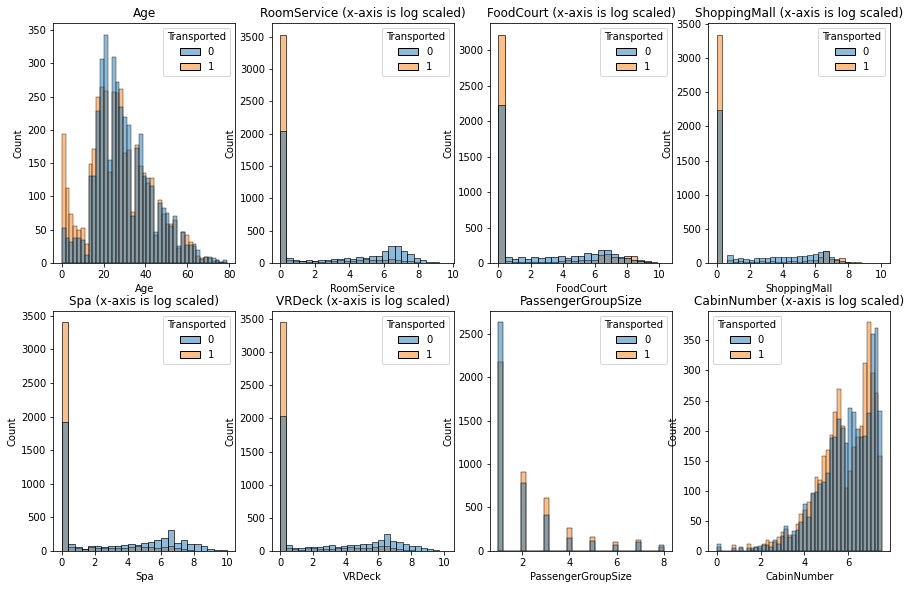

In [13]:
# Ploting counts of continous features
fig = plt.figure(figsize=(15., 15.))
for i, c in enumerate(continuous_features):
    ax = plt.subplot(3, 4, 1 + i)
    if c in ('Age', 'PassengerNumber', 'PassengerGroupSize'):
        ax = sns.histplot(data=train, x=c, hue='Transported')
        ax.set_title(c)
    else:
        # The range is very long so it should be log scaled for visibility.
        ax = sns.histplot(x=np.log1p(train[c]), hue=train['Transported'])
        ax.set_title(f'{c} (x-axis is log scaled)')

In [14]:
# Data description of features for each class of transported target variable
train.groupby('Transported')[continuous_features].describe()

Age                                                     \
              count       mean        std  min   25%   50%   75%   max   
Transported                                                              
0            4226.0  29.922858  13.699262  0.0  21.0  27.0  38.0  79.0   
1            4288.0  27.748834  15.151705  0.0  18.0  26.0  37.0  78.0   

            RoomService              ... PassengerGroupSize      CabinNumber  \
                  count        mean  ...                75%  max       count   
Transported                          ...                                       
0                4217.0  389.266066  ...                2.0  8.0      4216.0   
1                4295.0   63.098021  ...                3.0  8.0      4278.0   

                                                                        
                   mean         std  min    25%    50%     75%     max  
Transported                                                             
0            623.619070  525.438037  0.0  182.0  448.5  1060.0  1894.0  
1            577.453249  497.129959  0.0  154.0  385.0   964.0  1893.0  

[2 rows x 64 columns]

In [15]:
# creating a list of categorical variables
categorical_features = [c for c in train.select_dtypes(exclude='number').columns if c not in ('Transported', 'Cabin', 'Name', 'PassengerId', 'PassengerGroup')]
categorical_features

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

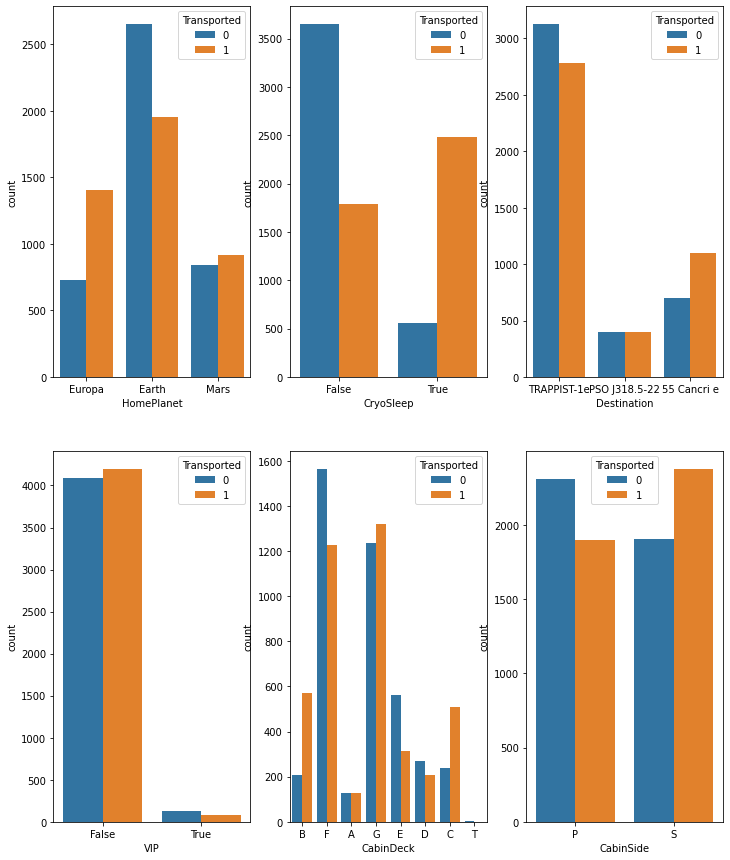

In [16]:
# Plotting counts of categorical features for each category in transported target variable
fig = plt.figure(figsize=(12, 15))
for i, c in enumerate(categorical_features):
    ax = plt.subplot(2, 3, 1 + i)
    ax = sns.countplot(data=train, x=c, hue='Transported')

In [17]:
# creating final training dataframe for building models
features = continuous_features + categorical_features
X = train[features].copy()  # Apply dimension reduction to this
X = pd.get_dummies(X, columns=categorical_features, drop_first=True, dummy_na=True)
X[continuous_features] = StandardScaler().fit_transform(X[continuous_features])
X[continuous_features] = SimpleImputer(strategy='median').fit_transform(X[continuous_features])
X

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroupSize,CabinNumber,HomePlanet_Europa,HomePlanet_Mars,...,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_nan,CabinSide_S,CabinSide_nan
0,0.702095,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.648735,-1.172966,1,0,...,1,0,0,0,0,0,0,0,0,0
1,-0.333233,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,-0.648735,-1.172966,0,0,...,0,0,0,0,1,0,0,0,1,0
2,2.013510,-0.272527,1.934922,-0.287317,5.634034,-0.223327,-0.022268,-1.172966,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0.287964,-0.337025,0.511931,0.326250,2.655075,-0.097634,-0.022268,-1.172966,1,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.885407,0.117466,-0.240833,-0.037590,0.223344,-0.264352,-0.648735,-1.171013,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.840138,-0.337025,3.947464,-0.287317,1.171754,-0.201506,-0.648735,-0.981499,1,0,...,0,0,0,0,0,0,0,0,0,0
8689,-0.747364,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.648735,1.755700,0,0,...,0,0,0,0,0,1,0,0,1,0
8690,-0.195189,-0.337025,-0.284274,2.808634,-0.272856,-0.266098,-0.648735,1.757654,0,0,...,0,0,0,0,0,1,0,0,1,0
8691,0.218942,-0.337025,0.366715,-0.287317,0.036829,2.557627,-0.022268,0.014912,1,0,...,0,0,0,1,0,0,0,0,1,0


In [18]:
# creating final dataframe for testing the models
X_test = train[features].copy()  # Apply dimension reduction to this
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True, dummy_na=True)
X_test[continuous_features] = StandardScaler().fit_transform(X_test[continuous_features])
X_test[continuous_features] = SimpleImputer(strategy='median').fit_transform(X_test[continuous_features])
X_test

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroupSize,CabinNumber,HomePlanet_Europa,HomePlanet_Mars,...,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_nan,CabinSide_S,CabinSide_nan
0,0.702095,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.648735,-1.172966,1,0,...,1,0,0,0,0,0,0,0,0,0
1,-0.333233,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,-0.648735,-1.172966,0,0,...,0,0,0,0,1,0,0,0,1,0
2,2.013510,-0.272527,1.934922,-0.287317,5.634034,-0.223327,-0.022268,-1.172966,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0.287964,-0.337025,0.511931,0.326250,2.655075,-0.097634,-0.022268,-1.172966,1,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.885407,0.117466,-0.240833,-0.037590,0.223344,-0.264352,-0.648735,-1.171013,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.840138,-0.337025,3.947464,-0.287317,1.171754,-0.201506,-0.648735,-0.981499,1,0,...,0,0,0,0,0,0,0,0,0,0
8689,-0.747364,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.648735,1.755700,0,0,...,0,0,0,0,0,1,0,0,1,0
8690,-0.195189,-0.337025,-0.284274,2.808634,-0.272856,-0.266098,-0.648735,1.757654,0,0,...,0,0,0,0,0,1,0,0,1,0
8691,0.218942,-0.337025,0.366715,-0.287317,0.036829,2.557627,-0.022268,0.014912,1,0,...,0,0,0,1,0,0,0,0,1,0


# Modeling

# PCA

In [19]:
#Perform PCA on training data

pca = PCA()
pca.fit(X)

# Using 21 principle components which capture 99 percent of the variablity in data
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X)
print('Number of PCs :',len(X_pca[0]))
print("Cumulative variance captured by PCs:")
pca.explained_variance_ratio_.cumsum()

Number of PCs : 21
Cumulative variance captured by PCs:


array([0.17523886, 0.30028223, 0.40313945, 0.49878172, 0.59162226,
       0.6762268 , 0.75152196, 0.82560191, 0.8587056 , 0.88411644,
       0.90842437, 0.92784402, 0.94439474, 0.95579762, 0.96454925,
       0.97216243, 0.9775867 , 0.9825291 , 0.98692253, 0.98936183,
       0.99175123])

In [20]:
#Perform PCA on testing data
pca_test = PCA()
pca_test.fit(X_test)

# Using 21 principle components which capture 99 percent of the variablity in data
pca_test = PCA(n_components=21)
X_pca_test = pca_test.fit_transform(X_test)
print('Number of PCs :',len(X_pca_test[0]))
print("Cumulative variance captured by PCs:")
pca_test.explained_variance_ratio_.cumsum()

Number of PCs : 21
Cumulative variance captured by PCs:


array([0.17523886, 0.30028223, 0.40313945, 0.49878172, 0.59162226,
       0.6762268 , 0.75152196, 0.82560191, 0.8587056 , 0.88411644,
       0.90842437, 0.92784402, 0.94439474, 0.95579762, 0.96454925,
       0.97216243, 0.9775867 , 0.9825291 , 0.98692253, 0.98936183,
       0.99175123])

# Logistic regression

In [21]:
# Training logistic regression model on training data

# Seperating Target variable
y = train['Transported']

# logistic regression model
lg = LogisticRegression(solver='liblinear').fit(X_pca, y )

# Predicting target training values
y_pred_train_lg = lg.predict(X_pca)

# Calculating accuracy of model on training data
lg_train_acu = round(accuracy_score(y, y_pred_train_lg),2)
print("Accuracy on Training data :",lg_train_acu)

# 5-fold cross validation 
cv_score_train_lg = cross_val_score(lg, X_pca, y, cv=5)
print("Accuracies from cross validation run: ", cv_score_train_lg)
print("Average cross validation accuracy: ",round(np.average(cv_score_train_lg), 2))

Accuracy on Training data : 0.79
Accuracies from cross validation run:  [0.77113283 0.78895917 0.79815986 0.787687   0.78078251]
Average cross validation accuracy:  0.79


In [22]:
# Predicting class values for Testing data using logistic regression model
y_pred_test_lg = lg.predict(X_pca_test)
print("Predictions of testing data: ",y_pred_test_lg)

Predictions of testing data:  [1 0 0 ... 1 0 1]


In [23]:
# calculating false positive rate and true positive rate for ROC curve
y_pred_proba_lg = lg.predict_proba(X_pca)[::,1]
fpr_lg, tpr_lg, _ = roc_curve(y,  y_pred_proba_lg)
print("False Positive Rates: ", fpr_lg,"\n True Positive Rates: ",tpr_lg)
auc_lg = roc_auc_score(y, y_pred_proba_lg)
print("ROC Accuracy Score: ", auc_lg)

False Positive Rates:  [0.         0.         0.         ... 0.90173812 0.90173812 1.        ] 
 True Positive Rates:  [0.00000000e+00 2.28414801e-04 2.69529466e-02 ... 9.99771585e-01
 1.00000000e+00 1.00000000e+00]
ROC Accuracy Score:  0.879698000166216


# Random Forest

In [24]:
# Training Random Forest model on Training data
rf = RandomForestClassifier(max_depth=8, random_state=4)
rf.fit(X_pca, y)

#predicting Target values for training data
y_pred_train_rf = rf.predict(X_pca)

# Calculating accuracy values on training predictions
rf_train_acu = round(accuracy_score(y, y_pred_train_rf), 2)
print("Accuracy on Training data :",rf_train_acu)

# 5-fold cross validation 
cv_score_train_rf = cross_val_score(rf, X_pca, y, cv=5)
print(cv_score_train_rf)
print("Accuracies from cross validation run: ", cv_score_train_rf)
print("Average cross validation accuracy: ",round(np.average(cv_score_train_rf), 2))

Accuracy on Training data : 0.85
[0.7573318  0.78723404 0.78953422 0.79056387 0.80034522]
Accuracies from cross validation run:  [0.7573318  0.78723404 0.78953422 0.79056387 0.80034522]
Average cross validation accuracy:  0.79


In [25]:
# Predicting class values for Testing data using Random Forest model
y_pred_test_rf = rf.predict(X_pca_test)
print("Predictions of testing data: ",y_pred_test_rf)

Predictions of testing data:  [0 0 0 ... 1 0 1]


In [26]:
# calculating false positive rate and true positive rate for ROC curve
y_pred_proba_rf = rf.predict_proba(X_pca)[::,1]
fpr_rf, tpr_rf, _ = roc_curve(y,  y_pred_proba_rf)
print(" False Positive Rates: ", fpr_rf,"\n True Positive Rates: ",tpr_rf)
auc_rf = roc_auc_score(y, y_pred_proba_rf)
print(" ROC Accuracy Score: ", auc_rf)


 False Positive Rates:  [0.         0.         0.         ... 0.86419467 0.86419467 1.        ] 
 True Positive Rates:  [0.00000000e+00 2.28414801e-04 1.37048881e-03 ... 9.99771585e-01
 1.00000000e+00 1.00000000e+00]
 ROC Accuracy Score:  0.9334535047511866


# MLP

In [27]:
# Training Multilevel perceptron model on Training data

model = Sequential()

#Building a sequential dense 3-layer neural network
# Input Layer
model.add(Dense(21, input_dim=21, activation='relu'))
# Hidden Layer
model.add(Dense(10, activation='relu'))  
# Output Layer - using sigmoid for binary classification
model.add(Dense(1, activation='sigmoid')) 

# Compiling model with binary_crossentropy loss
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Training the network
model.fit(X_pca,y, epochs=150, batch_size=100)

# Calculating loss and accuracy
loss, acc = model.evaluate(X_pca,y)
print(" Loss :", loss,"\n Accuracy :",acc)

# Predicting target values for Training data
y_pred_train_mlp =  model.predict_on_batch(X_pca)

# Predicting target values for Testing data
y_pred_test_mlp = model.predict_on_batch(X_pca_test)

Epoch 1/150
87/87 [==============================] - 1s 2ms/step - loss: 0.6285 - accuracy: 0.6898
Epoch 2/150
87/87 [==============================] - 0s 2ms/step - loss: 0.5251 - accuracy: 0.7726
Epoch 3/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.7827
Epoch 4/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.7881
Epoch 5/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4284 - accuracy: 0.7957
Epoch 6/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.7979
Epoch 7/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8009
Epoch 8/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8035
Epoch 9/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8021
Epoch 10/150
87/87 [==============================] - 0s 2ms/step - loss: 0.4041 - accuracy: 0.8031
Epoch 11/

In [28]:
# calculating false positive rate and true positive rate for ROC curve
fpr_mlp, tpr_mlp, _ = roc_curve(y,  y_pred_train_mlp)
print(" False Positive Rates: ", fpr_mlp,"\n True Positive Rates: ",tpr_mlp)
auc_mlp = roc_auc_score(y, y_pred_train_mlp)
print(" ROC Accuracy Score: ", auc_mlp)


 False Positive Rates:  [0.         0.         0.         ... 0.86998841 0.86998841 1.        ] 
 True Positive Rates:  [0.         0.00342622 0.00388305 ... 0.99977159 1.         1.        ]
 ROC Accuracy Score:  0.9263958314695778


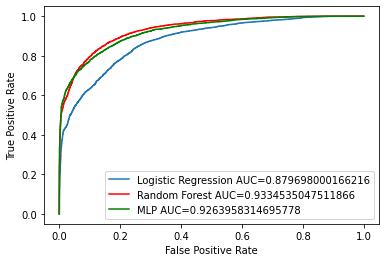

In [29]:
# Plotting ROC curve for logistic regression, Random Forest, Multilevel Perceptron model
#set up plotting area
plt.figure(0).clf()

plt.plot(fpr_lg,tpr_lg,label="Logistic Regression AUC="+str(auc_lg))
plt.plot(fpr_rf,tpr_rf,label="Random Forest AUC="+str(auc_rf),c = 'red' )
plt.plot(fpr_mlp,tpr_mlp,label="Multilevel Perceptron AUC="+str(auc_mlp),c = 'green' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
#add legend
plt.legend()